# Preprocess WAVs into mel-frequency cepstrum (MFC) JPEGs
This script is used to convert audio files from the AudioMNIST dataset, which are in the wav format, into MFC images.
The resulting images are used to train a CNN to recognise the speaker's gender. Credits: Some of the following  was inspired by project https://github.com/zhihanyang2022/gender_audio_classification by Zhihan Yang. Yang's original script produced images designed for input into ResNet. This script produces RGB images of dimension 98x12. Additional adjustments were made to the code so the code outputs no longer depends on a function, which was deprecated in SciPy since SciPy version 1.3.

## Import packages

In [1]:
import json
import os
import warnings

import librosa
import numpy as np
import scipy.io.wavfile
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt

from preprocess_mfc_util import audio_to_mfc

warnings.filterwarnings('ignore')

## Obtain file paths of AudioMNIST wav files

In [2]:
# git clone https://github.com/soerenab/AudioMNIST into adjacent folder
audio_dir = '../../AudioMNIST/data'
audio_meta_path = f'{audio_dir}/audioMNIST_meta.txt' # audio meta data (labels)

In [3]:
with open(audio_meta_path) as json_file:
    audio_meta = json.load(json_file)

In [4]:
male_idxs, female_idxs = [], []
for idx, info in audio_meta.items():
    if info['gender'].lower() == 'male':
        male_idxs.append(idx)
    elif info['gender'].lower() == 'female':
        female_idxs.append(idx)

In [5]:
print(f'Total male speakers: {len(male_idxs)}\nTotal female speakers: {len(female_idxs)}')

Total male speakers: 48
Total female speakers: 12


In [6]:
def get_wav_paths_from_speaker_indices(idxs):
    wav_fpaths = []
    for idx in idxs:
        for fname in os.listdir(f'{audio_dir}/{idx}'):
            wav_fpaths.append(f'{audio_dir}/{idx}/{fname}')
    return wav_fpaths

In [7]:
male_wav_fpaths = sorted(get_wav_paths_from_speaker_indices(male_idxs))
female_wav_fpaths = sorted(get_wav_paths_from_speaker_indices(female_idxs))

In [8]:
# Ensure same order across runs
np.random.seed(13)
np.random.shuffle(male_wav_fpaths)
np.random.shuffle(female_wav_fpaths)

In [9]:
wav_fpaths = male_wav_fpaths + female_wav_fpaths

In [10]:
print(wav_fpaths[0:9])

['../../AudioMNIST/data/08/8_08_17.wav', '../../AudioMNIST/data/37/0_37_9.wav', '../../AudioMNIST/data/35/5_35_8.wav', '../../AudioMNIST/data/31/3_31_20.wav', '../../AudioMNIST/data/24/9_24_18.wav', '../../AudioMNIST/data/09/2_09_11.wav', '../../AudioMNIST/data/15/4_15_20.wav', '../../AudioMNIST/data/01/7_01_25.wav', '../../AudioMNIST/data/38/5_38_28.wav']


### Obtain max length of input sample

In [11]:
sample_rate = librosa.core.get_samplerate(wav_fpaths[0])
print(sample_rate)

48000


In [12]:
max_duration = 0.9999583333333333 # slightly less than 1s
print(max_duration)

0.9999583333333333


In [13]:
max_samples = int(max_duration * sample_rate)
print(max_samples)

47998


## Output MFC JPEGs

In [14]:
mfc_dataset_dir = '../mfc_dataset'

Create a one-to-one mapping between MFC JPEG names and WAV names.

In [15]:
male_idxs_to_wav_fpaths = {}
for i, fp in tqdm_notebook(enumerate(male_wav_fpaths), total=len(male_wav_fpaths)):
    male_idxs_to_wav_fpaths[f'{mfc_dataset_dir}/male_{i}.jpg'] = fp

female_idxs_to_wav_fpaths = {}
for i, fp in tqdm_notebook(enumerate(female_wav_fpaths), total=len(female_wav_fpaths)):
    female_idxs_to_wav_fpaths[f'{mfc_dataset_dir}/female_{i}.jpg'] = fp

  0%|          | 0/24000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

In [16]:
with open('../audio_to_mfc_maps/male_idxs_to_wav_fpaths.json', 'w+') as json_f:
    json.dump(male_idxs_to_wav_fpaths, json_f)

with open('../audio_to_mfc_maps/female_idxs_to_wav_fpaths.json', 'w+') as json_f:
    json.dump(female_idxs_to_wav_fpaths, json_f)

In [ ]:
np.random.seed(1)
for i, fp in tqdm_notebook(enumerate(male_wav_fpaths), total=len(male_wav_fpaths)):
    _, audio_input = scipy.io.wavfile.read(fp)
    mfc = audio_to_mfc(audio_input, sample_rate, max_samples)
    if i == 0:
        plt.imshow(mfc)
    plt.imsave(f'{mfc_dataset_dir}/male_{i}.jpg', mfc)

  0%|          | 0/24000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

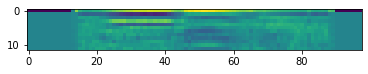

In [27]:
np.random.seed(2)
for i, fp in tqdm_notebook(enumerate(female_wav_fpaths), total=len(female_wav_fpaths)):
    _, audio_input = scipy.io.wavfile.read(fp)  # faster than librosa
    mfc = audio_to_mfc(audio_input, sample_rate, max_samples)
    if i == 0:
        plt.imshow(mfc)
    plt.imsave(f'{mfc_dataset_dir}/female_{i}.jpg', mfc)